In [74]:
!pip install fuzzywuzzy

# Movie Production Analysis

## Business Sense

- Define the best timeline to roll out original content
    - movies profit margin per movie by release month
    - number and gross of movies per month grouped by genre
- Define the production budget and prifit margin
    - find a sweet spot that optimizes profit wrt production budget
    - look for actors and directors that make movies at the budget level

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
%matplotlib inline

In [99]:
mojo_df       = pd.read_csv    ('../zippedData/bom.movie_gross.csv.gz')
rt_info_df    = pd.read_csv    ('../zippedData/rt.movie_info.tsv.gz', sep='\t', encoding='iso8859_1')
rt_review_df  = pd.read_csv    ('../zippedData/rt.reviews.tsv.gz'   , sep='\t', encoding='iso8859_1')
imdb_title_df = pd.read_csv    ('../zippeddata/imdb.title.basics.csv.gz')
tmbd_df       = pd.read_csv    ('../zippedData/tmdb.movies.csv.gz'  , index_col=0)
tn_df         = pd.read_csv    ('../zippedData/tn.movie_budgets.csv.gz')

# Regarding Month to Roll out Original Material
## Using The Numbers

In [100]:
tn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


- Converting the string date to datetime64

In [101]:
tn_df.release_date = pd.DatetimeIndex(tn_df.release_date)

- Adding day, month, and year columns to the data set

In [102]:
tn_df['day']   = tn_df.release_date.dt.dayofweek
tn_df['month'] = tn_df.release_date.dt.month
tn_df['year']  = tn_df.release_date.dt.year

- Find the year range of the data set.

In [103]:
tn_df.year.min(),tn_df.year.max()

(1915, 2020)

- Only look at movies that were released after 1960.

In [104]:
tn_df = tn_df[tn_df['year'] > 1960]

- Converting the grossing and budget columns to float type

In [105]:
tn_df['production_budget'] = tn_df['production_budget']\
    .str.replace(',','').str.replace('$',"").astype(float)

In [106]:
tn_df['domestic_gross'] = tn_df['domestic_gross']\
    .str.replace(',','').str.replace('$',"").astype(float)

In [107]:
tn_df['worldwide_gross'] = tn_df['worldwide_gross']\
    .str.replace(',','').str.replace('$',"").astype(float)

In [108]:
tn_df = tn_df[(tn_df['production_budget'] > 0.0)]
tn_df = tn_df[tn_df['worldwide_gross'] > 0.0]
tn_df = tn_df[tn_df['domestic_gross'] > 0.0]

- Adding new column for net profit domestic and world

In [109]:
tn_df['world_net'] = tn_df['worldwide_gross'] - tn_df['production_budget']

In [110]:
tn_df['domestic_net'] = tn_df['domestic_gross'] - tn_df['production_budget']

## - Regarding the World/Domestic Profits Relative to Month of Release

- Set up variables grouped on month that hold the sum of world net and domestic net respectively by month

In [111]:
world_ave_net_per_movie = tn_df.groupby('month').sum()['world_net']\
    /tn_df.groupby('month').count()['movie']
domestic_ave_net_per_movie = tn_df.groupby('month').sum()['domestic_net']\
    /tn_df.groupby('month').count()['movie']

- Setting up month map for graphing

In [112]:
month_map = {0:'January',1:'Febuary',2:'March',3:'April',4:'May',5:'June',6:'July',7:'August',8:'September',9:'October',10:'November',11:'December'}

Text(0, 0.5, 'Average Net Income/Movie (in Millions)')

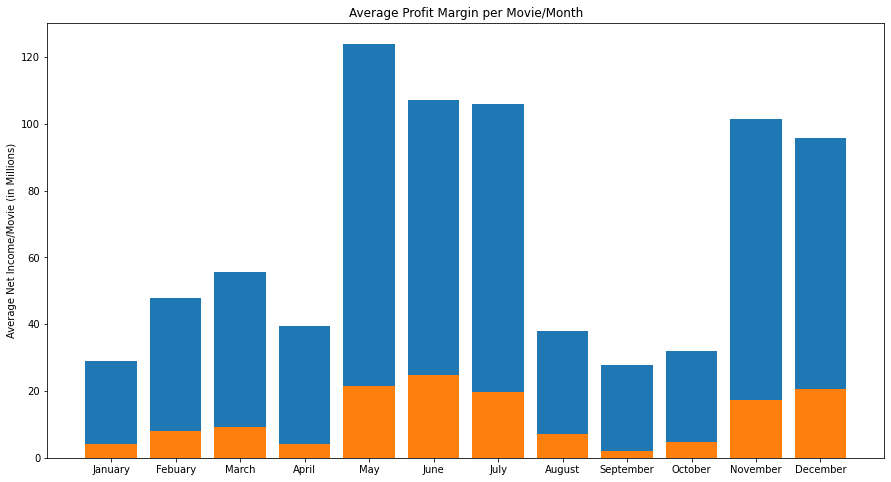

In [113]:
fig, ax = plt.subplots(figsize=(15,8))
ax.bar(month_map.values(),world_ave_net_per_movie/1000000)
ax.bar(month_map.values(),domestic_ave_net_per_movie/1000000)
ax.set_title('Average Profit Margin per Movie/Month')
ax.set_ylabel('Average Net Income/Movie (in Millions)')

This plot of the net prifits of films released after 1960 shows the total net profits of movies divided by the number of movies in the month that they were released. This gives an Idea of the average net profit per movie given a specific month. Judging from this comparrison, it can be concluded that the months that generally yeild the most profit for a new release are the Summer months of May,June,July and the holliday months of November and December.

# Regarding What Genre of Movie to Release During Prime Seasons
## Using iMDB and The Numbers Datasets

In [114]:
imdb_title_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


- Cleaning the iMDB Title Basic Table

- Dropping the rows with NaN values for genre

In [115]:
imdb_title_df = imdb_title_df.dropna(subset=['genres'])

### - Handling Redundancies in the movie title

- Checking for redundancies in the data.

In [116]:
imdb_title_df = imdb_title_df.drop_duplicates()

- Checking for Movies with the same primary title and different release years.

In [117]:
imdb_title_df['unique_id'] = imdb_title_df['primary_title'] + '_' + imdb_title_df['start_year'].astype(str)

- Make sure there are no duplicates in the "unique_id"

In [118]:
imdb_title_df['unique_id'].value_counts()

Ângelo de Sousa - Tudo o Que Sou Capaz_2010         7
Split_2016                                          6
Homecoming_2011                                     4
The Return_2016                                     4
Inside Out_2011                                     4
                                                   ..
What She Wants for Christmas_2012                   1
Reintegration: A Documentary About Parolees_2011    1
Jwlwi - The Seed_2019                               1
Kokolampy_2016                                      1
La bataille du charbon_2017                         1
Name: unique_id, Length: 138926, dtype: int64

In [119]:
imdb_title_df[imdb_title_df['unique_id'] == 'Ângelo de Sousa - Tudo o Que Sou Capaz_2010']

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,unique_id
66989,tt3815122,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.0,"Biography,Documentary",Ângelo de Sousa - Tudo o Que Sou Capaz_2010
66990,tt3815124,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.0,"Biography,Documentary",Ângelo de Sousa - Tudo o Que Sou Capaz_2010
66991,tt3815126,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.0,"Biography,Documentary",Ângelo de Sousa - Tudo o Que Sou Capaz_2010
66992,tt3815128,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.0,"Biography,Documentary",Ângelo de Sousa - Tudo o Que Sou Capaz_2010
66993,tt3815130,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.0,"Biography,Documentary",Ângelo de Sousa - Tudo o Que Sou Capaz_2010
66994,tt3815132,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.0,"Biography,Documentary",Ângelo de Sousa - Tudo o Que Sou Capaz_2010
66995,tt3815134,Ângelo de Sousa - Tudo o Que Sou Capaz,Ângelo de Sousa - Tudo o Que Sou Capaz,2010,60.0,"Biography,Documentary",Ângelo de Sousa - Tudo o Que Sou Capaz_2010


- Looks like the tconst column is the only one that does not contain redundancies so we drop all but one.

In [120]:
imdb_title_df.drop_duplicates(subset=['unique_id'],inplace=True)

- Last Check

In [121]:
imdb_title_df['unique_id'].value_counts()

Replicas_2018                                                                           1
Revision_2012                                                                           1
I Heart NY_2017                                                                         1
Waterlily Jaguar_2018                                                                   1
Eiga Purikyua ôru sutâzu DX 3: Mirai ni todoke! Sekai o tsunagu nijiiro no hana_2011    1
                                                                                       ..
Bizim Köyün Sarkisi_2018                                                                1
Thakita Thakita_2010                                                                    1
Ami O Manohor_2018                                                                      1
Vibration: The Symphony of Life_2017                                                    1
La bataille du charbon_2017                                                             1
Name: uniq

- Making sure that there is a matching id key in The Numbers to join the tables.

In [122]:
tn_df['unique_id'] = tn_df['movie'] + '_' + tn_df['year'].astype(str)

In [123]:
tn_df['unique_id'] = tn_df['unique_id'].str.replace(' ','').str.lower()

In [124]:
def remove_special(unique_id):
    new_id = ''.join(e for e in unique_id if e.isalnum())
    return new_id.lower()

In [125]:
tn_df['unique_id'] = tn_df['unique_id'].map(remove_special)
imdb_title_df['unique_id'] = imdb_title_df['unique_id'].map(remove_special)

In [126]:
imdb_title_df['unique_id']

0                                   sunghursh2013
1                  onedaybeforetherainyseason2019
2                       theothersideofthewind2018
3                               sabsebadasukh2018
4                       thewanderingsoapopera2017
                           ...                   
146138                       thesecretofchina2019
146139                      kuambillagihatiku2019
146140    rodolphoteóphiloolegadodeumpioneiro2015
146141                         dankyavardanka2013
146143             chicoalbuquerquerevelações2013
Name: unique_id, Length: 138926, dtype: object

- Using FuzzyWuzzy to match titles

'100jaarschipholluchtzakenonderdezeespiegel2016'

### - Joining iMBD and The Numbers

In [127]:
tf_imdb_df = tn_df.set_index('unique_id').join(imdb_title_df.set_index('unique_id'),how = 'inner')

- Checking the new table values

In [128]:
tf_imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1373 entries, 10cloverfieldlane2016 to zootopia2016
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1373 non-null   int64         
 1   release_date       1373 non-null   datetime64[ns]
 2   movie              1373 non-null   object        
 3   production_budget  1373 non-null   float64       
 4   domestic_gross     1373 non-null   float64       
 5   worldwide_gross    1373 non-null   float64       
 6   day                1373 non-null   int64         
 7   month              1373 non-null   int64         
 8   year               1373 non-null   int64         
 9   world_net          1373 non-null   float64       
 10  domestic_net       1373 non-null   float64       
 11  tconst             1373 non-null   object        
 12  primary_title      1373 non-null   object        
 13  original_title     1373 non-null   objec

# Regarding Whether to go into Foreign Markets or Stay Domestic
Looking at the trend of foreign profit margin vs. the domestic profit margin for the years between 2010 2018

In [129]:
tn_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5151 entries, 0 to 5781
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5151 non-null   int64         
 1   release_date       5151 non-null   datetime64[ns]
 2   movie              5151 non-null   object        
 3   production_budget  5151 non-null   float64       
 4   domestic_gross     5151 non-null   float64       
 5   worldwide_gross    5151 non-null   float64       
 6   day                5151 non-null   int64         
 7   month              5151 non-null   int64         
 8   year               5151 non-null   int64         
 9   world_net          5151 non-null   float64       
 10  domestic_net       5151 non-null   float64       
 11  unique_id          5151 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(4), object(2)
memory usage: 523.1+ KB


In [130]:
tn_df['foreign_gross'] = tn_df.worldwide_gross - tn_df.domestic_gross

In [131]:
margin_by_year = tn_df.groupby('year').sum()

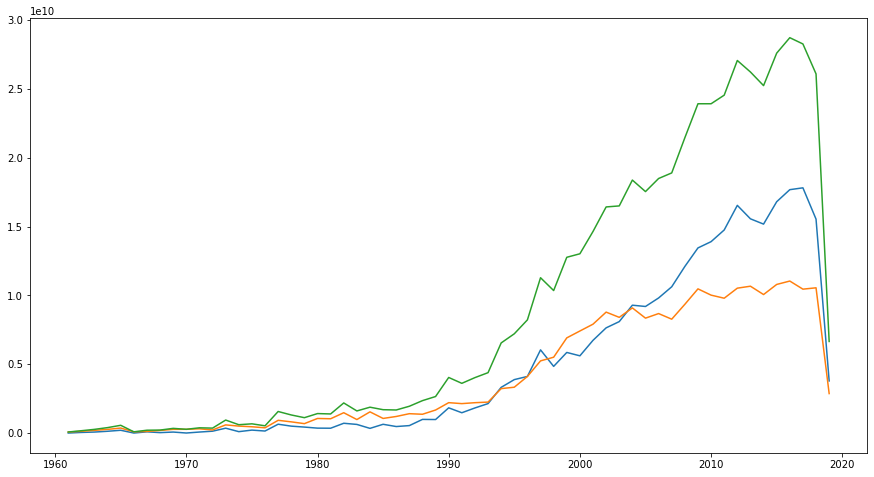

In [132]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(margin_by_year.foreign_gross)
ax.plot(margin_by_year.domestic_gross)
ax.plot(margin_by_year.worldwide_gross)

- seems like the 2018 data is incomplete likely because the data ended during that year. Removing that data.

In [133]:
tn_df = tn_df[tn_df['year'] < 2018]
tn_df['year'].max()
margin_by_year = tn_df.groupby('year').sum()

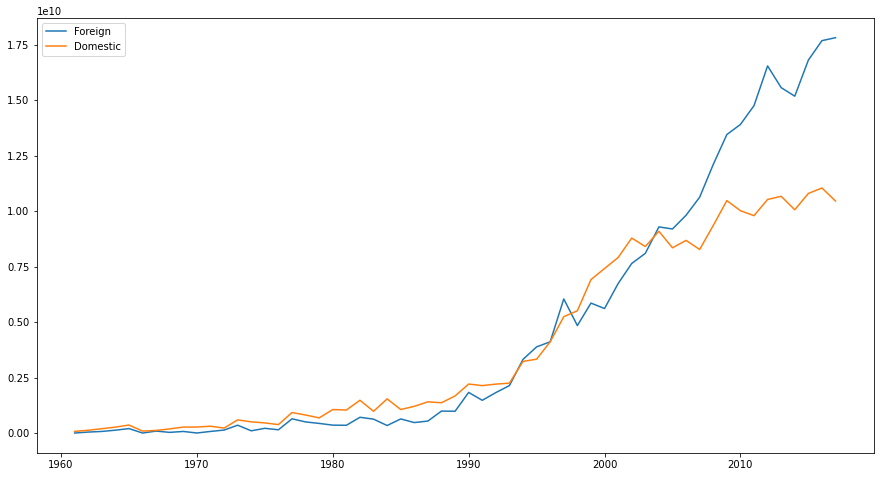

In [138]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(margin_by_year.foreign_gross)
ax.plot(margin_by_year.domestic_gross)
ax.legend(['Foreign','Domestic'])

# Regarding What Genre of Movies to Make

In [141]:
imdb_title_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138926 entries, 0 to 146143
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           138926 non-null  object 
 1   primary_title    138926 non-null  object 
 2   original_title   138924 non-null  object 
 3   start_year       138926 non-null  int64  
 4   runtime_minutes  110759 non-null  float64
 5   genres           138926 non-null  object 
 6   unique_id        138926 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 13.5+ MB


In [153]:
imdb_title_df['genres'] = imdb_title_df['genres'].str.strip().str.replace(',',' ').str.split()

In [155]:
all_genres = []
for index, row in imdb_title_df.iterrows():
    all_genres.extend(row.genres)
unique_genres = set(all_genres)

{'Action',
 'Adult',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western'}